In [1]:
import pandas as pd
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from itertools import product
import scipy.stats as ss

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier

from sklearn.model_selection import KFold, cross_val_score

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df.shape

(7043, 21)

# Data Understanding

## Column Name

In [4]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Column Type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


There is not null value in any column. The data type of SeniorCitizen is not consistent with other categorical variables, it uses [0, 1] to represent category. TotalCharges should be in float but it is object data type so need further investigation.

# Data Cleaning

## Check missing value

In [6]:
any(df.isnull().any(axis=0))

False

It is consistent with the information above where there is no null value in any column.

In [7]:
df = df.replace(' ', np.nan)

In [8]:
any(df.isnull().any(axis=0))

True

Null value exist after converting empty string (' ') to null value. There is column using empty string to represent missing value.

In [9]:
anyNull = df.isnull().any(axis=0)
Nan_col = anyNull.index[anyNull]
Nan_col

Index(['TotalCharges'], dtype='object')

TotalCharges is the column using empty string. That explain why it's data type is object.

In [10]:
for col in Nan_col:
    display(pd.DataFrame(df[df[col].isnull()]))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


There are 11 rows of data with missing value in TotalCharges

In [11]:
df = df.dropna()
df.shape

(7032, 21)

Remove rows with null value. We can afford that because we have 7000+ records.

In [12]:
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')

Convert TotalCharges back to float data type.\
Convert SeniorCitizen to category because it should be categorical variable. (not really necessary)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   object  
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   object  
 4   Dependents        7032 non-null   object  
 5   tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   object  
 7   MultipleLines     7032 non-null   object  
 8   InternetService   7032 non-null   object  
 9   OnlineSecurity    7032 non-null   object  
 10  OnlineBackup      7032 non-null   object  
 11  DeviceProtection  7032 non-null   object  
 12  TechSupport       7032 non-null   object  
 13  StreamingTV       7032 non-null   object  
 14  StreamingMovies   7032 non-null   object  
 15  Contract          7032 non-null   object  
 16  PaperlessBilling  7032 non-nu

## Check data integrity

In [14]:
# people with no phoneService cannot have MultipleLines
if 'Yes' in df.groupby(['PhoneService']).MultipleLines.unique()['No']:
    print('Have MultipleLines without PhoneService')

internet_service = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_service:
    if not ['No internet service'] == df.groupby(['InternetService'])[col].unique()['No']:
        print('Have additional services without internet service')

It is not possible to have customer without phone service owning multiple lines.\
It is also not possible to have customer without internet service having additional internet services.

## Number of unique value in each column

In [15]:
df.apply(lambda col: len(col.unique()))

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

# Data Visualisation

In [16]:
colors = ['#3D3B40', '#525CEB', '#BFCFE7', '#F8EDFF']

def bar_plot(features):
    
    if isinstance(features, str):
        fig, ax = plt.subplots()
        draw_bar(features, ax)
        
    elif isinstance(features, list):
        row_num = 0
        col_num = 0
        
        if len(features)%2 == 0:
            row_num = int(len(features)/2)
            col_num = 2
            fig, axs = plt.subplots(row_num, col_num, figsize = (10, 5))
        elif len(features)%3 == 0:
            row_num = int(len(features)/3)
            col_num = 3
            fig, axs = plt.subplots(row_num, col_num, figsize = (15, 15))
            fig.tight_layout(pad=5.0)
             
        i = 0
        for row in range(row_num):
            for col in range(col_num):
                feature = features[i]
                if row_num == 1:
                    draw_bar(feature, axs[i])
                else:
                    draw_bar(feature, axs[row, col])
                i += 1
                
    plt.show()

def draw_bar(feature, ax):
    count_df = df[feature].value_counts().sort_index().to_frame().reset_index()
    
    if len(df[feature].unique()) == 3 and set(['No', 'Yes']).issubset(df[feature].unique()):
        count_df = count_df.reindex([0, 2, 1]).reset_index(drop = True)
    
    perc_df = count_df['count']/sum(count_df['count'])*100
    
#     display(count_df)
#     display(perc_df)
#     print(count_df[feature])
#     print(perc_df)

    ax.bar(count_df[feature], perc_df, color = colors[:len(df[feature].unique())], width = 0.5)

    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_title(f"{feature} Distribution")
    ax.set_ylabel('% Customer')
    ax.set_xlabel(feature)
    ax.set_ylim(0, max(perc_df) * 1.1)
        
    for j in ax.patches:
        if len(ax.patches) == 2:   
            ax.text(j.get_x() + 0.15, j.get_height() + 0.5, f'{round(j.get_height(), 2)}%')
        else:
            ax.text(j.get_x() + 0.08, j.get_height() + 0.5, f'{round(j.get_height(), 2)}%')
            
    if len(ax.patches) == 4:
        ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 45, ha = 'right')

## Customer Demographics
Visualise the personal information of customers

### Gender

In [17]:
# gender_count = df['gender'].value_counts().sort_index().to_frame().reset_index()
# gender_perc = gender_count['count']/sum(gender_count['count'])*100

# fig, ax = plt.subplots()
# ax.bar(gender_count['gender'], gender_perc, color = ['pink','grey'], width = 0.5)


# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_title("Gender Distribution")
# ax.set_ylabel('% Customer')
# ax.set_xlabel('Gender')
# ax.set_ylim(0, max(gender_perc) * 1.1)

# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_height() + 0.5, f'{round(i.get_height(), 2)}%')

# plt.show()

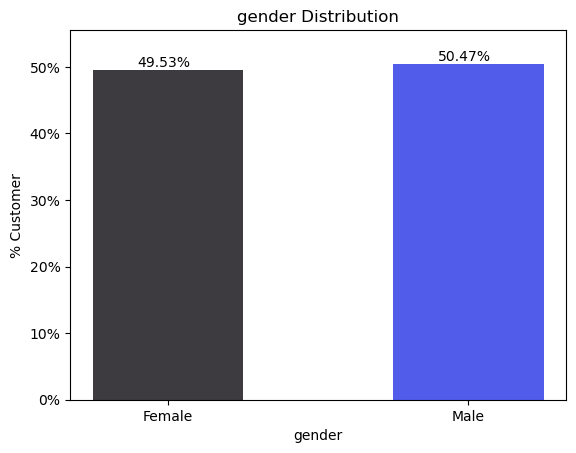

In [18]:
bar_plot('gender')

Half of the customer in the dataset is Female and another half is Male

### Senior Citizen

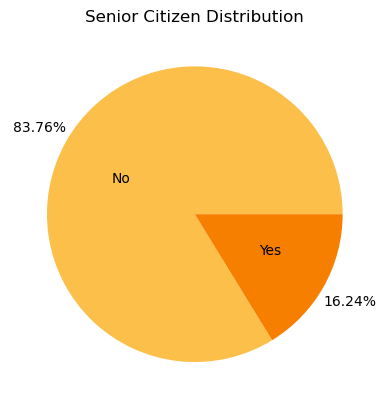

In [19]:
seniorCitizen_count = df['SeniorCitizen'].value_counts().sort_index().to_frame().reset_index()
seniorCitizen_count['SeniorCitizen'] = ['No' if x == 0 else 'Yes' for x in seniorCitizen_count['SeniorCitizen']]
seniorCitizen_count_perc = seniorCitizen_count['count']/sum(seniorCitizen_count['count'])*100

fig, ax = plt.subplots()
ax.pie(seniorCitizen_count_perc, labels = seniorCitizen_count['SeniorCitizen'], 
       autopct = '%1.2f%%', colors = ['#fcbf49', '#f77f00'],
       pctdistance = 1.2, labeldistance = 0.5)

ax.set_title("Senior Citizen Distribution")
plt.show()

Majority of the cutomers are not senior citizen. Senior citizen customer is only slightly above 15%.

### Partner and Dependent

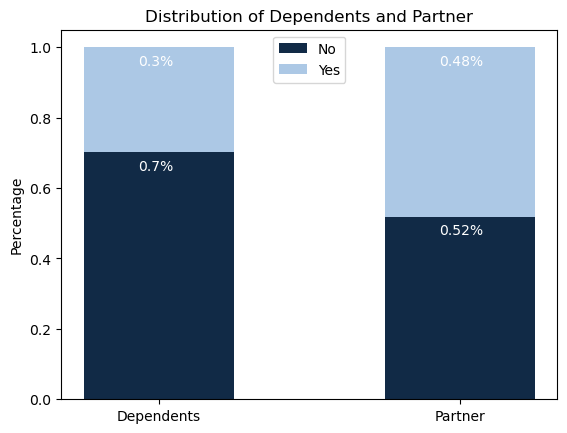

In [20]:
df2 = pd.melt(df, id_vars=['customerID'], value_vars=['Dependents','Partner'])
df3 = df2.groupby(['variable','value']).count().unstack()
df3 = df3.loc[:,'customerID']

fig, ax = plt.subplots()
bottom = np.zeros(2)
# colors = ['#112A46', '#ACC8E5']
for i, col in enumerate(df3.columns):
    ax.bar(df3.index, df3[col]/len(df), 0.5, label = col, bottom = bottom, color = ['#112A46', '#ACC8E5'][i])
    bottom += df3[col]/len(df)

for i in ax.patches:
    ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

ax.legend(loc="upper center")
ax.set_title('Distribution of Dependents and Partner')
ax.set_ylabel('Percentage')

plt.show()

Half of the customer have partner and another half does not have partner. Only 30% of the customer have dependents.

## Customer Information
Visualise the telecom account of the customers

### Tenure

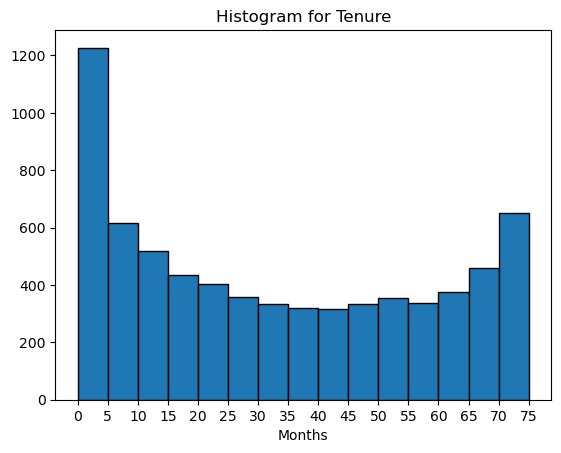

In [21]:
fig, ax = plt.subplots()

# sns.boxplot(x = 'Churn', y = 'tenure', data = df, ax = axs[0])
# axs[0].set_title(f'Box Plot for Tenure')

ax.hist(df['tenure'], bins = np.arange(0, 80, 5), edgecolor='black')
ax.set_title(f'Histogram for Tenure')
ax.set_xticks(np.arange(0, 80, 5))
ax.set_xlabel('Months')
# ax.set_xticklabels(axs[1].get_xticks(), fontsize = 8)

plt.show()

More than 1200 customers are short term customer (0-5 months).\
Customer are clustered around (0-15 months) or (65-75 months). This may depends on their contract where it may be easy for the customer to terminate the contract (month-to-month) or more difficult as they have one-year or two-year contract.

### Phone Service and Multiple Lines

In [22]:
# fig, axs = plt.subplots(1, 2, figsize = (10, 5))
# phone_list = ['PhoneService', 'MultipleLines', ]
# colors = ['#3636C9', '#7F36C9', '#3680C9']

# for i, service in enumerate(phone_list):
#     count_df = df[service].value_counts().sort_index().to_frame().reset_index()
#     if i == 1:
#         count_df = count_df.reindex([0, 2, 1]).reset_index(drop = True)
#     count_perc = count_df['count']/sum(count_df['count'])*100
    
#     axs[i].bar(count_df[service], count_perc, color = colors[:i+2], width = 0.5)

#     axs[i].yaxis.set_major_formatter(mtick.PercentFormatter())
#     axs[i].set_title(f"{service} Distribution")
#     axs[i].set_ylabel('% Customer')
#     axs[i].set_xlabel(service)
#     axs[i].set_ylim(0, max(count_perc) * 1.1)

#     for j in axs[i].patches:
#         if len(axs[i].patches) == 2:   
#             axs[i].text(j.get_x() + 0.15, j.get_height() + 0.5, f'{round(j.get_height(), 2)}%')
#         else:
#             axs[i].text(j.get_x() + 0.08, j.get_height() + 0.5, f'{round(j.get_height(), 2)}%')
            

# plt.show()

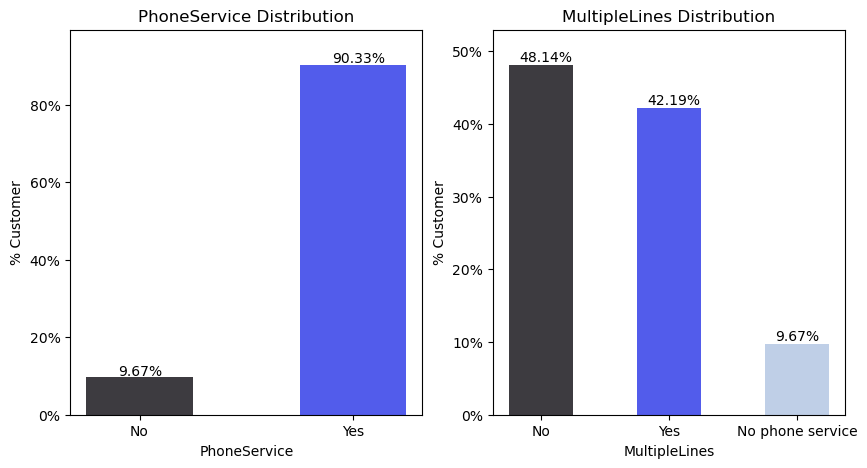

In [23]:
bar_plot(['PhoneService', 'MultipleLines'])

More than 90% of the customer have phone service which is exected. More than 40% of the customer have multiple phone lines. Almost half of the customer with phone service have multiple lines.

### Services

In [24]:
# service_list = df.columns[6:-6].to_list()

# fig, axs = plt.subplots(3, 3, figsize = (15, 15))
# fig.tight_layout(pad=5.0)
# colors = ['#3636C9', '#7F36C9', '#3680C9']
# label_format = '{:,.0f}'
# size = 15

# def draw_bar(service, ax):
#     count_df = df[service].value_counts().sort_index().to_frame().reset_index()
#     if len(df[service].unique()) == 3 and set(['No', 'Yes']).issubset(df[service].unique()):
#         count_df = count_df.reindex([0, 2, 1]).reset_index(drop = True)
#     count_perc = count_df['count']/sum(count_df['count'])*100
    
#     ax.bar(count_df[service], count_perc, color = colors[:i+2], width = 0.5)

# #     ax.yaxis.set_major_formatter(mtick.PercentFormatter())
#     ax.set_title(f"{service} Distribution")
#     ax.set_ylabel('% Customer')
#     ax.set_xlabel(service)
#     ax.set_ylim(0, max(count_perc) * 1.1)
    
#     #fix the bug in matplotlib
# #     ticks_loc = ax.get_xticks()
# #     ax.set_xticks(ax.get_xticks())
# #     ax.set_xticklabels([label_format.format(x) for x in ticks_loc])
    
# #     ticks_loc = ax.get_yticks()
# #     ax.set_yticks(ax.get_yticks())
# #     ax.set_yticklabels([label_format.format(x) for x in ticks_loc])
    
# #     ax.set_xticks(ax.get_xticks())
# #     ax.set_xticklabels(ax.get_xticks())
# #     ax.set_xticks(ax.get_yticks())
# #     ax.set_yticklabels(ax.get_yticks())

#     for j in ax.patches:
#         if len(ax.patches) == 2:   
#             ax.text(j.get_x() + 0.15, j.get_height() + 0.5, f'{round(j.get_height(), 2)}%')
#         else:
#             ax.text(j.get_x() + 0.08, j.get_height() + 0.5, f'{round(j.get_height(), 2)}%')

# i = 0
# for row in range(3):
#     for col in range(3):
#         feature = service_list[i]
#         draw_bar(feature, axs[row, col])
#         i += 1

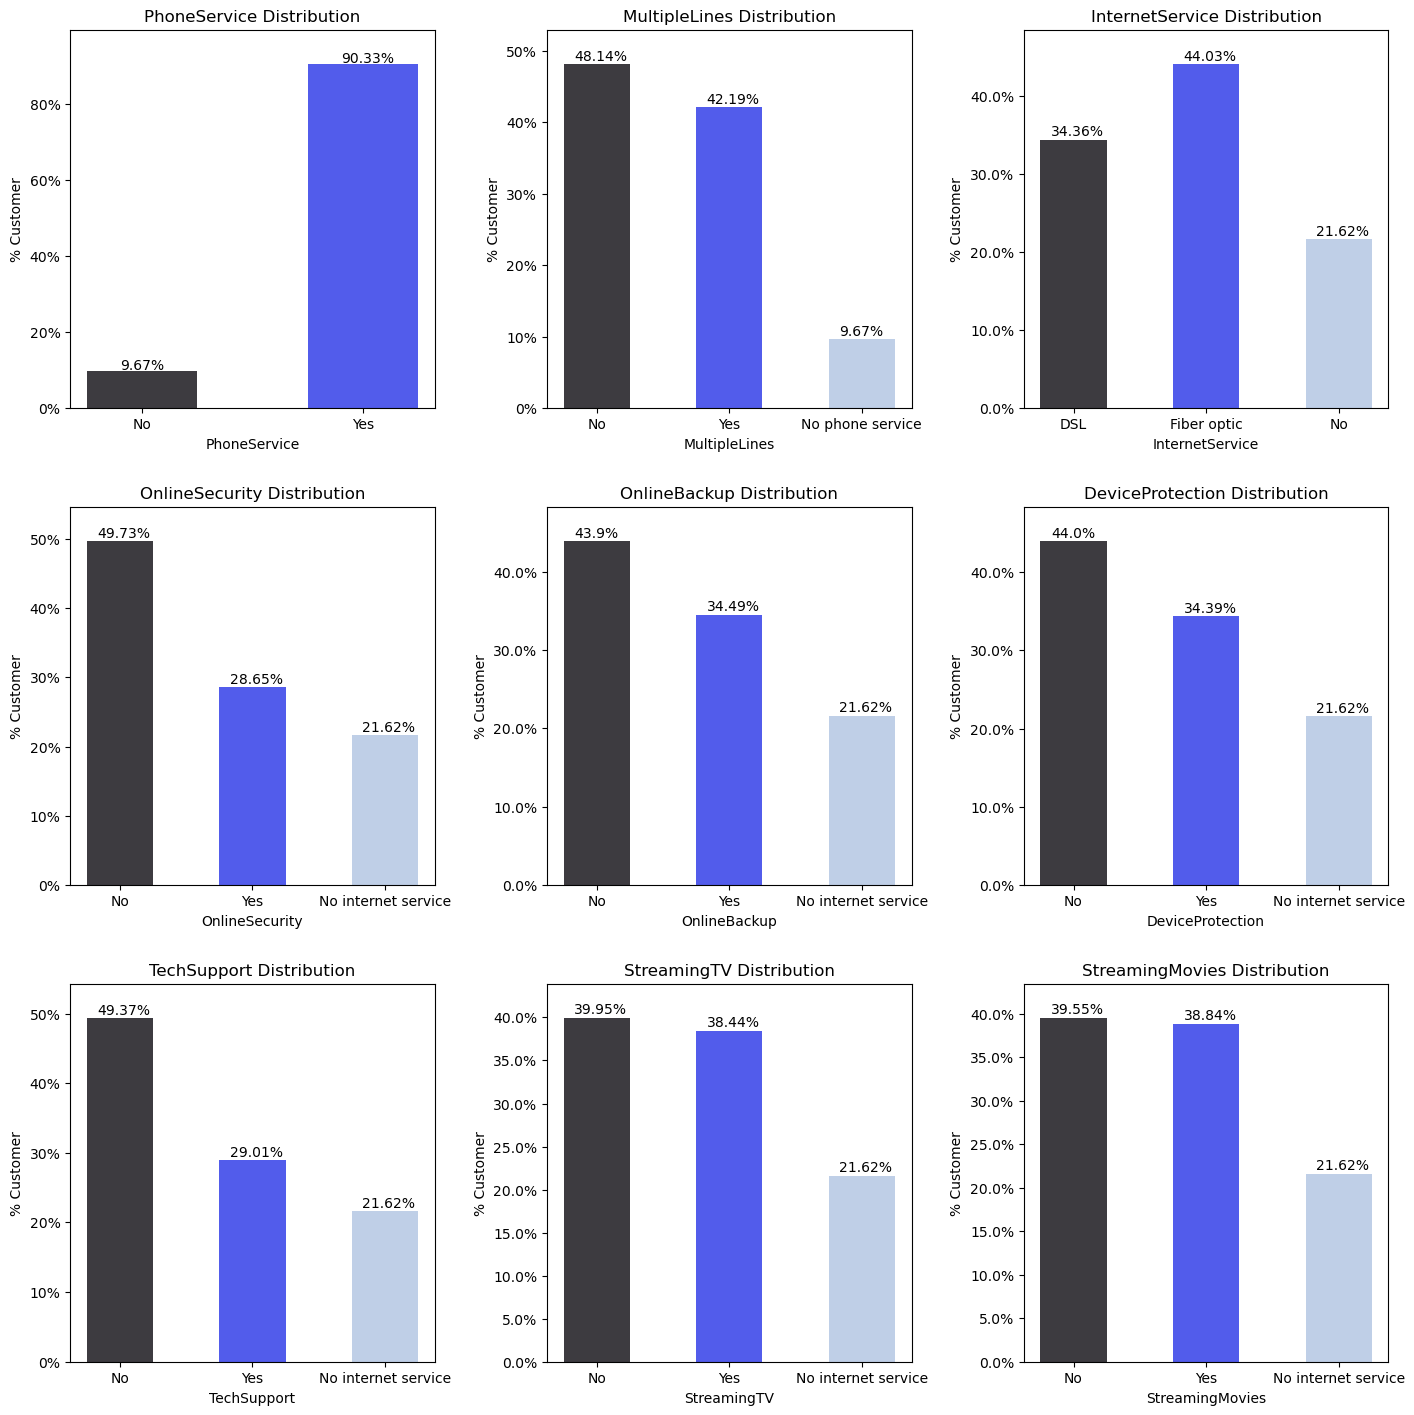

In [25]:
bar_plot(df.columns[6:-6].to_list())

Arounf 22% of the customer does not have a internet services. Around 44% of the customer uses fiber optic internet services whilst the remaining uses DSL. Almost half of the customer doesn't have a online security service. In terms of Online Backup and Device Protection, around 44% of the customer doesn't subcribe to them. Almost half of the customer also doesn't have a Tech SUpport service. Among customer who have internet services, roughly half of them have streaming TV and Movies services. Based on the visualisation above, more customer will not have utility based services. When it comes to entertaining services, almost half of the customers with internet services also subcribe to them.

### Contract

In [26]:
# contract_count = df['Contract'].value_counts().sort_index().to_frame().reset_index()
# contract_perc = contract_count['count']/contract_count['count'].sum()*100

# fig, ax = plt.subplots()
# ax.bar(contract_count['Contract'], contract_perc, color = ['#E5E1DA','#AAD7D9', '#92C7CF'], width = 0.5)


# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_title("Contract Distribution")
# ax.set_ylabel('% Customer')
# ax.set_xlabel('Contract')
# ax.set_ylim(0, max(contract_perc) * 1.1)

# for i in ax.patches:
#     ax.text(i.get_x() + 0.12, i.get_height() + 0.5, f'{round(i.get_height(), 2)}%')

# plt.show()

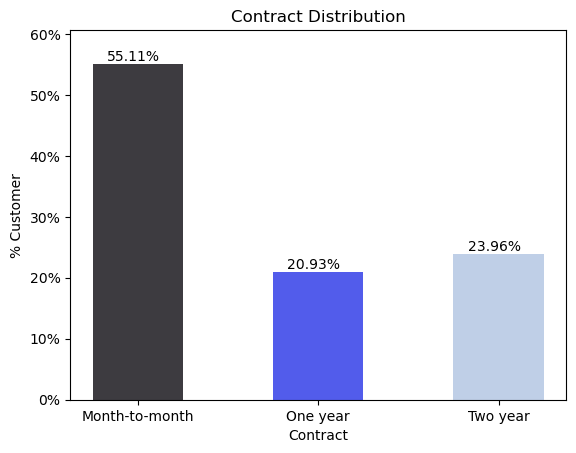

In [27]:
bar_plot('Contract')

More than 50% of the customers have a month-to-month contract. There is less amount of customers who have one year contract than two year contract. This may due to once they have decided to stay with the company, two year contract will have better benefits or lower monthly payment.

### PaperlessBilling

In [28]:
# billing_count = df['PaperlessBilling'].value_counts().sort_index().to_frame().reset_index()
# billing_perc = billing_count['count']/billing_count['count'].sum()*100

# fig, ax = plt.subplots()
# ax.bar(billing_count['PaperlessBilling'], billing_perc, color = ['#AAD7D9', '#92C7CF'], width = 0.5)


# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_title("Billing Distribution")
# ax.set_ylabel('% Customer')
# ax.set_xlabel('Billing')
# ax.set_ylim(0, max(billing_perc) * 1.1)

# for i in ax.patches:
#     ax.text(i.get_x() + 0.16, i.get_height() + 0.5, f'{round(i.get_height(), 2)}%')

# plt.show()

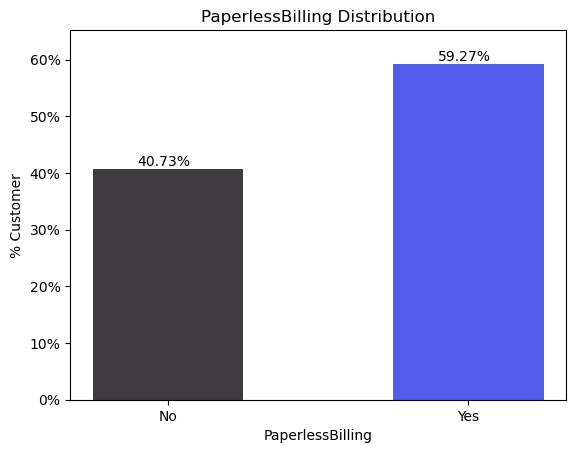

In [29]:
bar_plot('PaperlessBilling')

Almost 60% of the customer uses paperless billing. 

### PaymentMethod

In [30]:
# payment_count = df['PaymentMethod'].value_counts().sort_index().to_frame().reset_index()
# payment_perc = payment_count['count']/payment_count['count'].sum()*100

# fig, ax = plt.subplots()
# ax.bar(payment_count['PaymentMethod'], payment_perc, color = ['#EEF5FF', '#B4D4FF', '#86B6F6', '#176B87'], width = 0.5)


# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_title("Payment Distribution")
# ax.set_ylabel('% Customer')
# ax.set_xlabel('Payment')
# ax.set_ylim(0, max(payment_perc) * 1.1)

# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation = 45, ha = 'right')

# for i in ax.patches:
#     ax.text(i.get_x() + 0.05, i.get_height() + 0.5, f'{round(i.get_height(), 2)}%')

# plt.show()

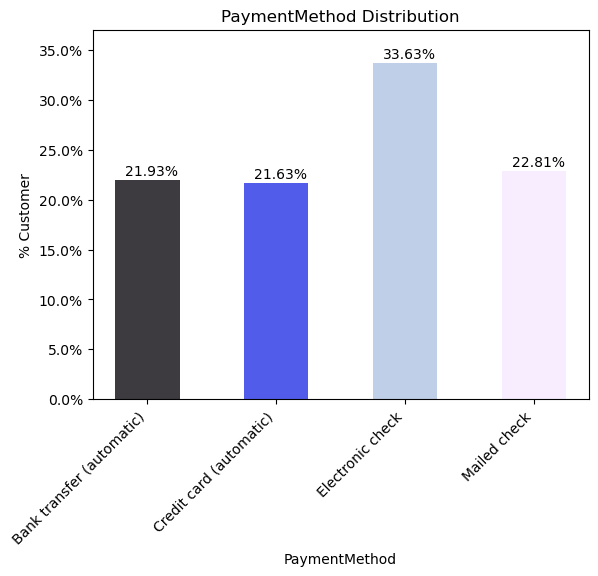

In [31]:
bar_plot('PaymentMethod')

Larger amount of customers uses electronic check to pay their bill. The remaining customers who uses the other 3 payment methods are evenly distributed.

## Churn

In [32]:
# churn_count = df['Churn'].value_counts().sort_index().to_frame().reset_index()
# churn_perc = churn_count['count']/churn_count['count'].sum()*100

# fig, ax = plt.subplots()
# ax.bar(churn_count['Churn'], churn_perc, color = ['#3636C9', '#7F36C9'], width = 0.5)


# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# ax.set_title("Billing Distribution")
# ax.set_ylabel('% Customer')
# ax.set_xlabel('Billing')
# ax.set_ylim(0, max(churn_perc) * 1.1)

# for i in ax.patches:
#     ax.text(i.get_x() + 0.16, i.get_height() + 0.5, f'{round(i.get_height(), 2)}%')

# plt.show()

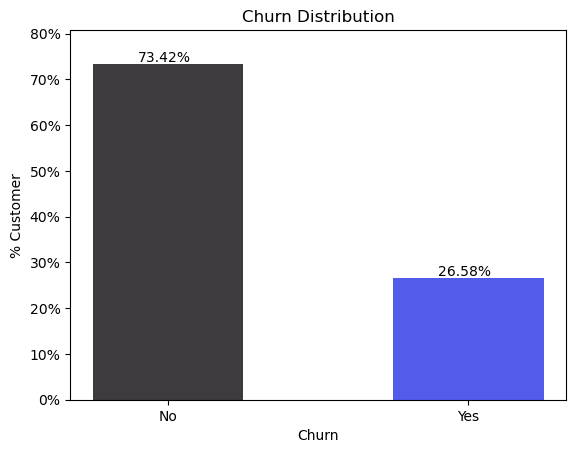

In [33]:
bar_plot('Churn')

This is a imbalance dataset where there is significantly more customer not churn (more than 70%). 

## Relation between two variable

In [34]:
def stacked_bar_plot(main, perc = 'Churn'):
    count_df = pd.crosstab(df[perc], df[main], margins = False)

    if {0, 1}.issubset(set(count_df.columns)):
        count_df.columns = ['No', 'Yes']
    elif {0, 1}.issubset(set(count_df.index)):
        count_df.index = ['No', 'Yes']
    
    total = count_df.sum(axis = 0)

    fig, ax = plt.subplots()
    bottom = np.zeros(len(count_df.columns))
    for i, col in enumerate(count_df.index):
        ax.bar(count_df.columns, count_df.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
        bottom += count_df.loc[col]/total
        
    for i in ax.patches:
        if i.get_height() < 0.08 and len(ax.patches) == 4:
            ax.text(i.get_x() + 0.18, i.get_y() + i.get_height(), f'{round(i.get_height(), 2)}%', color = 'black')
        elif i.get_height() > 0.08 and len(ax.patches) == 4:
            ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')
        elif i.get_height() < 0.08 and len(ax.patches) >= 6:
            ax.text(i.get_x() + 0.125, i.get_y() + i.get_height(), f'{round(i.get_height(), 2)}%', color = 'black')
        elif i.get_height() > 0.08 and len(ax.patches) >= 6:
            ax.text(i.get_x() + 0.125, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')
            
    ax.legend(loc="upper center", title = perc)
    
    if len(ax.patches) > 4:
        ax.legend(loc=(0.6, 0.8), title = perc)
    
    ax.set_title(f'Distribution of {perc} in {main}')
    ax.set_xlabel(f'{main}')
    ax.set_ylabel('Percentage')
    
    plt.show()
    
def correlation(feature1, feature2 = 'Churn'):
    p_val = list(ss.chi2_contingency(pd.crosstab(df[feature1], df[feature2])))[1]
#     print(f'P-value: {p_val:.2f}')
    print(f'P-value: {p_val}')

### Dependents and Partner

In [35]:
# Dep_Part_count = pd.crosstab(df['Dependents'], df['Partner'], margins = False)
# total = Dep_Part_count.sum(axis = 0)

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['#112A46', '#ACC8E5']
# for i, col in enumerate(Dep_Part_count.index):
#     ax.bar(Dep_Part_count.columns, Dep_Part_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Dep_Part_count.loc[col]/total
    
# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')z

# ax.legend(loc="upper center", title = 'Dependents')
# ax.set_title('Distribution of Dependents in Partner')
# ax.set_xlabel('Partner')
# ax.set_ylabel('Percentage')

# plt.show()

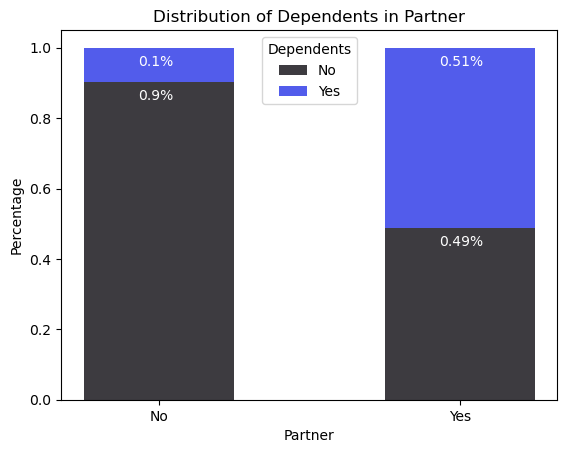

P-value: 0.0


In [36]:
stacked_bar_plot('Partner', 'Dependents')
correlation('Partner', 'Dependents')

There is 10% of the customers who have dependents even they do not have partner. Only half of the customers who have partner also have dependents. Based on the p-value, we can conclude that there is a correlationship between partner and dependents. Although it is obvious but still cannot assume causation.

## Gender and Senior Citizen

In [37]:
# Gen_Senior_count = pd.crosstab(df['gender'], df['SeniorCitizen'], margins = False)
# Gen_Senior_count.columns = ['No', 'Yes']

# total = Gen_Senior_count.sum(axis = 0)

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['pink', 'grey']
# for i, col in enumerate(Gen_Senior_count.index):
#     ax.bar(Gen_Senior_count.columns, Gen_Senior_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Gen_Senior_count.loc[col]/total
    
# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

# ax.legend(loc="upper center", title = 'Gender')
# ax.set_title('Distribution of Gender in Senior Citizen')
# ax.set_xlabel('Senior Citizen')
# ax.set_ylabel('Gender')

# plt.show()

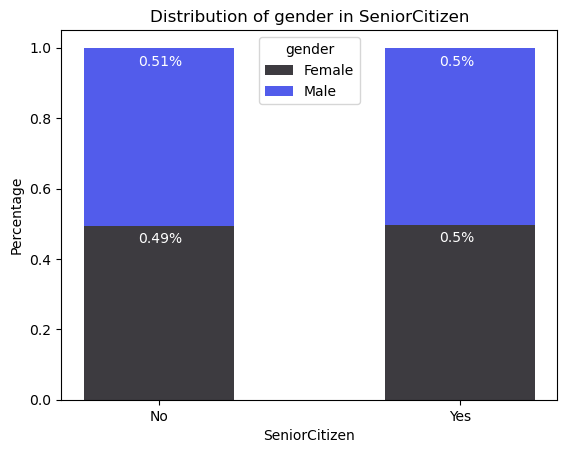

P-value: 0.9042977456032477


In [38]:
stacked_bar_plot('SeniorCitizen', 'gender')
correlation('SeniorCitizen', 'gender')

There is even amount of female and male customers in young and senior citizen. It is almost certain that there is no relaionship between gender and senior citizen.

## Monthly and Total Charges

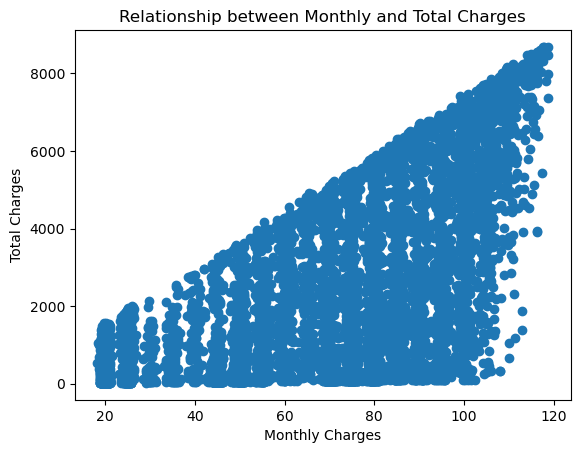

,MonthlyCharges,TotalCharges
MonthlyCharges,1.000000,0.651065
TotalCharges,0.651065,1.000000


In [39]:
fig, ax = plt.subplots()

ax.scatter(df['MonthlyCharges'], df['TotalCharges'])
ax.set_title('Relationship between Monthly and Total Charges')
ax.set_xlabel('Monthly Charges')
ax.set_ylabel('Total Charges')

plt.show()

df[['MonthlyCharges', 'TotalCharges']].corr()

The scatter plot shows an increasing trend. The higher the monthly charges, the higher the total charges. However, there are customers who pays much lower total charges even they have a high monthly charges. This may due to they have some subsidies or there is a recording error. Since there is large amount of customers who have such cases, there is less likely to be recording error. The pearson correlation shows that there is a positive relationship between Monthly and Total Charges.

## Tenure and Monthly Charges

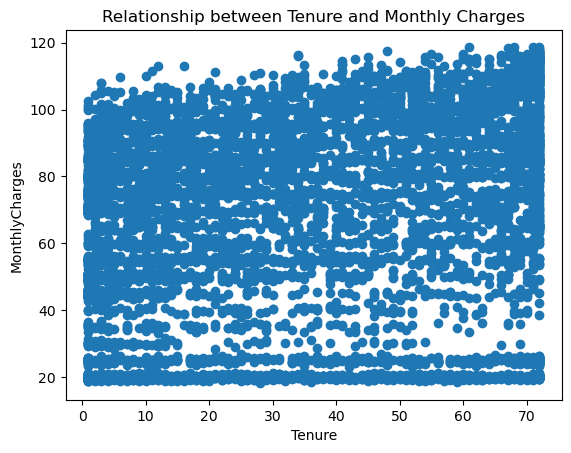

,tenure,MonthlyCharges
tenure,1.000000,0.246862
MonthlyCharges,0.246862,1.000000


In [40]:
fig, ax = plt.subplots()

ax.scatter(df['tenure'], df['MonthlyCharges'])
ax.set_title('Relationship between Tenure and Monthly Charges')
ax.set_xlabel('Tenure')
ax.set_ylabel('MonthlyCharges')

plt.show()

df[['tenure', 'MonthlyCharges']].corr()

There is no clear pattern between tenure and monthly charges. This is expected as customers will have different monthly charges depends on the services they subcribe to regardless of the tenure.  The pearson correlation also support this conclusion where there is only a weak correlation.

## Tenure and Total Charges

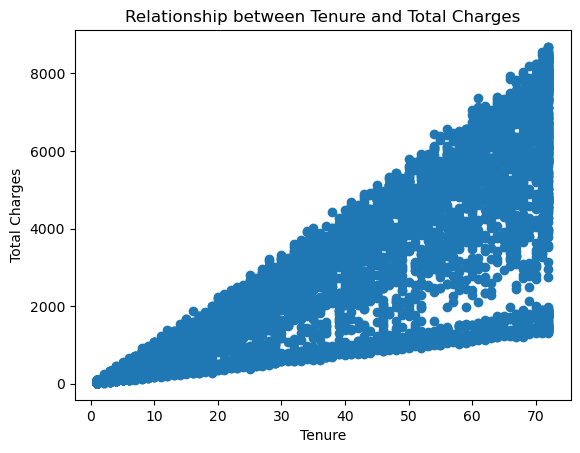

,tenure,TotalCharges
tenure,1.00000,0.82588
TotalCharges,0.82588,1.00000


In [41]:
fig, ax = plt.subplots()

ax.scatter(df['tenure'], df['TotalCharges'])
ax.set_title('Relationship between Tenure and Total Charges')
ax.set_xlabel('Tenure')
ax.set_ylabel('Total Charges')

plt.show()

df[['tenure', 'TotalCharges']].corr()

Customers with larger tenure usually have a higher total charges. However due to the subsidies as mentioned above, customers with high tenure may be paying a low total charges. The pearson correlation support that there is a strong positive relationship between tenure and total charges.

## Churn and Gender 

In [42]:
# Gen_Churn_count = pd.crosstab(df['gender'], df['Churn'])
# display(Gen_Churn_count)

# total = Gen_Churn_count.sum()

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['pink', 'grey']
# for i, col in enumerate(Gen_Churn_count.index):
#     ax.bar(Gen_Churn_count.columns, Gen_Churn_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Gen_Churn_count.loc[col]/total
    
# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

# ax.legend(loc="upper center", title = 'Gender')
# ax.set_title('Distribution of Gender in Churn')
# ax.set_xlabel('Churn')
# ax.set_ylabel('Gender')

# plt.show()

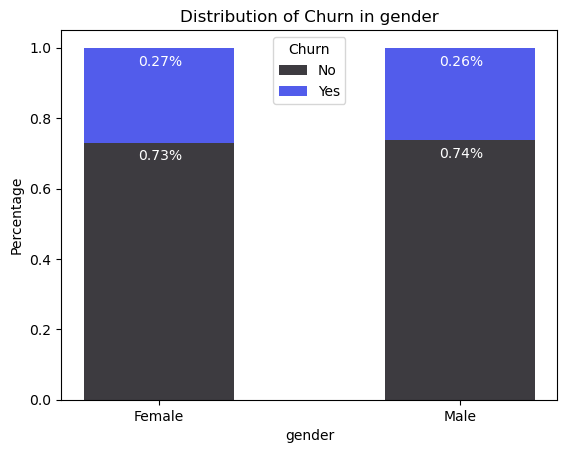

P-value: 0.4904884707065509


In [43]:
stacked_bar_plot('gender')
correlation('gender')

There is almost 75% of the customers does not churn in both female and male customers. This is expected as the female and male customers are evenly distributed and the not churn customers is almost 75% of the dataset. The p-value allow us to reject that there is a correlation.

## Churn and Senior Citizen

In [44]:
# Senior_Churn_count = pd.crosstab(df['SeniorCitizen'], df['Churn'])
# Senior_Churn_count.index = ['No', 'Yes']
# display(Senior_Churn_count)

# total = Senior_Churn_count.sum()

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['#112A46', '#ACC8E5']
# for i, col in enumerate(Senior_Churn_count.index):
#     ax.bar(Senior_Churn_count.columns, Senior_Churn_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Senior_Churn_count.loc[col]/total
    
# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

# ax.legend(loc="upper center", title = 'Senior Citizen')
# ax.set_title('Distribution of Gender in Churn')
# ax.set_xlabel('Churn')
# ax.set_ylabel('Gender')

# plt.show()

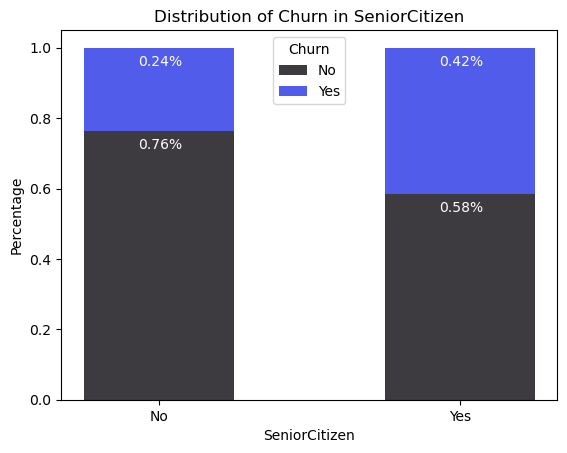

P-value: 2.4792557203954705e-36


In [45]:
stacked_bar_plot('SeniorCitizen')
correlation('SeniorCitizen')

More than 75% of the young citizen does not churn. There is more than 40% of the senior citizen decided to leave the company. The p-value allow us to reject the null hypothesis that there is no correlation between churn and senior citizen supporting senior citizen have a higher chance to churn.

## Churn and Partner

In [46]:
# Partner_Churn_count = pd.crosstab(df['Partner'], df['Churn'])
# display(Partner_Churn_count)

# total = Partner_Churn_count.sum()

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['#112A46', '#ACC8E5']
# for i, col in enumerate(Partner_Churn_count.index):
#     ax.bar(Partner_Churn_count.columns, Partner_Churn_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Partner_Churn_count.loc[col]/total
    
# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

# ax.legend(loc="upper center", title = 'Partner')
# ax.set_title('Distribution of Partner in Churn')
# ax.set_xlabel('Churn')
# ax.set_ylabel('Partner')

# plt.show()

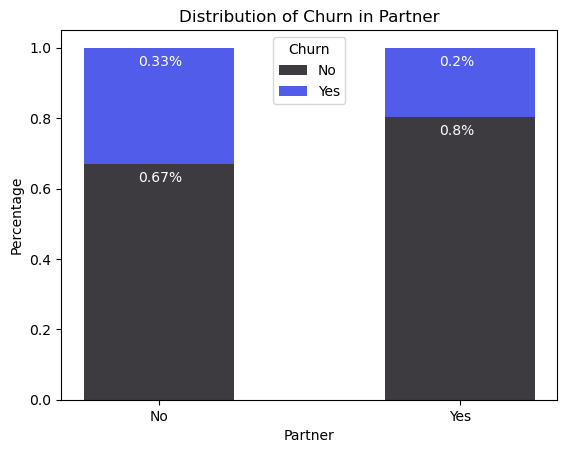

P-value: 3.97379757451591e-36


In [47]:
stacked_bar_plot('Partner')
correlation('Partner')

Customers without partner have a higher chance to churn (around 33%). Only 20% of the customer with partner churn. The p-value allow us to reject the null hypothesis so there is correlation between partner and churn.

## Churn and Dependents

In [48]:
# Dep_Churn_count = pd.crosstab(df['Dependents'], df['Churn'])
# display(Dep_Churn_count)

# total = Dep_Churn_count.sum()

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['#112A46', '#ACC8E5']
# for i, col in enumerate(Dep_Churn_count.index):
#     ax.bar(Dep_Churn_count.columns, Dep_Churn_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Dep_Churn_count.loc[col]/total
    
# for i in ax.patches:
#     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

# ax.legend(loc="upper center", title = 'Dependents')
# ax.set_title('Distribution of Dependents in Churn')
# ax.set_xlabel('Churn')
# ax.set_ylabel('Dependents')

# plt.show()

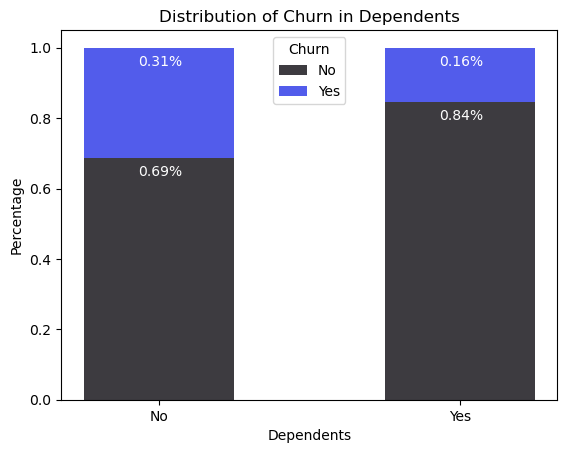

P-value: 2.0196592017051303e-42


In [49]:
stacked_bar_plot('Dependents')
correlation('Dependents')

Customer without dependents have a 31% churn rate. Customers with dependents is less likely to churn which is only 16%. This is similar cases to senior citizen and partner for p-value which allow us to reject the null hypothesis.

## Churn and Tenure

Text(0.5, 1.0, 'Box Plot for Tenure')

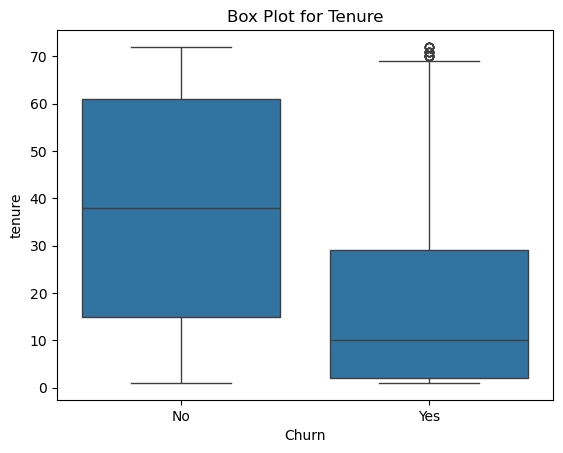

In [50]:
fig, ax = plt.subplots()

sns.boxplot(x='Churn', y='tenure', data=df, ax = ax)
ax.set_title(f'Box Plot for Tenure')

Customers who churn have a significantly lower quantiles for tenure which is lower than the median tenure of the customer who does not churn. This indicates that short term customers with month-to-month and one year contract is more likely to churn. 

## Churn and Contract

In [51]:
# Con_Churn_count = pd.crosstab(df['Contract'], df['Churn'])
# display(Con_Churn_count)

# total = Con_Churn_count.sum()

# fig, ax = plt.subplots()
# bottom = np.zeros(2)
# colors = ['#3636C9', '#7F36C9', '#3680C9']
# for i, col in enumerate(Con_Churn_count.index):
#     ax.bar(Con_Churn_count.columns, Con_Churn_count.loc[col]/total, 0.5, label = col, bottom = bottom, color = colors[i])
#     bottom += Con_Churn_count.loc[col]/total
    
# for i in ax.patches:
# #     ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')
#     if i.get_height() < 0.08:
#         ax.text(i.get_x() + 0.18, i.get_y() + i.get_height(), f'{round(i.get_height(), 2)}%', color = 'black')
#     else:
#         ax.text(i.get_x() + 0.18, i.get_y() + i.get_height() - 0.05, f'{round(i.get_height(), 2)}%', color = 'white')

# ax.legend(loc="upper center", title = 'Dependents', fontsize = 8)
# ax.set_title('Distribution of Dependents in Churn')
# ax.set_xlabel('Churn')
# ax.set_ylabel('Dependents')

# plt.show()

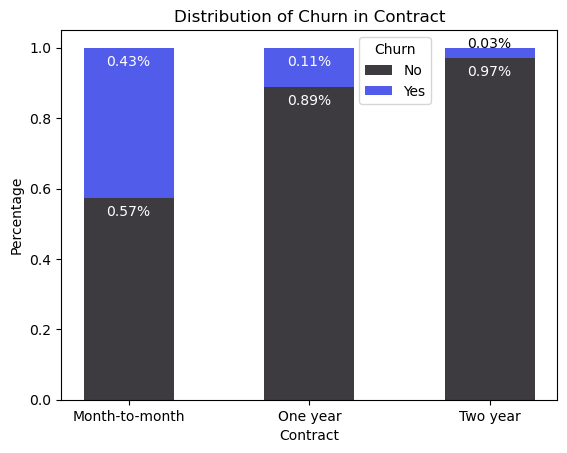

P-value: 7.326182186265472e-257


In [52]:
stacked_bar_plot('Contract')
correlation('Contract')

This bar plot supports the statement above where customer with two years contract have a significantly lower churn rate than customers with month-to-month and one year contract. Almost 45% of the customers with month-to-month contract churn and around 11% of the customers with one year contract churn. It seems like Contract have correlation with Churn with the p-value being very low so allowing us to reject null hypothesis.

## Churn and Monthly Charges

Text(0.5, 1.0, 'Box Plot for Monthly Charges')

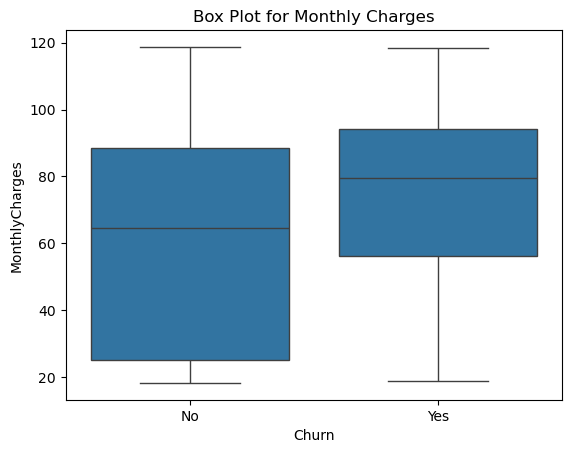

In [53]:
fig, ax = plt.subplots()

sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax = ax)
ax.set_title(f'Box Plot for Monthly Charges')

Customers who churn have a noticeable higher monthly charges than those who did not. This may be the reason why customers decided to leave. 

## Churn and Total Charges

Text(0.5, 1.0, 'Box Plot for Total Charges')

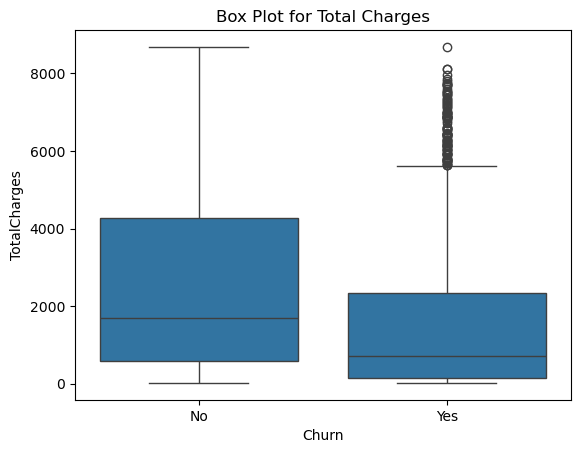

In [54]:
fig, ax = plt.subplots()

sns.boxplot(x='Churn', y='TotalCharges', data=df, ax = ax)
ax.set_title(f'Box Plot for Total Charges')

Customers who churn have a lower total charges because they usually have a lower tenure.

## Correlation

In [55]:
obj_cols = df.select_dtypes('object').apply(lambda col: len(col.unique()))
cat_cols = obj_cols[obj_cols <= 4].index
cat_df = df[cat_cols]

In [56]:
cat_var_prod = list(product(cat_cols, cat_cols, repeat = 1))

#Calculate Chi-Square Test for all feature pair
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0], i[1], 
                       list(ss.chi2_contingency(
                           pd.crosstab(cat_df[i[0]], cat_df[i[1]])))[1]))
# display(result)

#Churn correlation
churn_corr = []
related_feature = []
for pair in result:
    if 'Churn' == pair[0]:
        pair = list(pair)
        if pair[2] < 0.05:
            pair.append('Got Correlation')
            churn_corr.append(pair)
            related_feature.append(pair[1])
        else:
            pair.append('No Correlation')
            churn_corr.append(pair)
display(churn_corr)

#Check whether each variable is correlated
# exist = []
# related_pair = []
# for pair in result:
#     if {pair[0], pair[1]} not in exist:
#         exist.append({pair[0], pair[1]})
#         if pair[2] < 0.05:
#             related_pair.append(pair)
# display(related_pair)

[['Churn', 'gender', 0.4904884707065509, 'No Correlation'],
 ['Churn', 'Partner', 3.97379757451591e-36, 'Got Correlation'],
 ['Churn', 'Dependents', 2.0196592017051303e-42, 'Got Correlation'],
 ['Churn', 'PhoneService', 0.34992398942431924, 'No Correlation'],
 ['Churn', 'MultipleLines', 0.0035679273999811405, 'Got Correlation'],
 ['Churn', 'InternetService', 5.831198962236941e-159, 'Got Correlation'],
 ['Churn', 'OnlineSecurity', 1.4006867477839222e-184, 'Got Correlation'],
 ['Churn', 'OnlineBackup', 7.776099238804965e-131, 'Got Correlation'],
 ['Churn', 'DeviceProtection', 1.9593887862403176e-121, 'Got Correlation'],
 ['Churn', 'TechSupport', 7.407807748843288e-180, 'Got Correlation'],
 ['Churn', 'StreamingTV', 1.3246411131691968e-81, 'Got Correlation'],
 ['Churn', 'StreamingMovies', 5.353560421401323e-82, 'Got Correlation'],
 ['Churn', 'Contract', 7.326182186264635e-257, 'Got Correlation'],
 ['Churn', 'PaperlessBilling', 8.236203353962564e-58, 'Got Correlation'],
 ['Churn', 'PaymentM

# Data Transformation for modeling

In [57]:
seed = 99

In [58]:
from sklearn.model_selection import train_test_split

related_feature.extend(['tenure', 'MonthlyCharges', 'TotalCharges'])

# X = df.iloc[:,1:-1]
X = df[related_feature]
y = df.iloc[:,-1]

y.replace(to_replace='Yes', value=1, inplace=True)
y.replace(to_replace='No',  value=0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed)

C:\Users\khais\AppData\Local\Temp\ipykernel_9940\3270708713.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y.replace(to_replace='No',  value=0, inplace=True)


Only uses features that have correlation to Churn based on the Chi-Square Test and added continuous variable features that have relation to Churn based on Box Plot. Transform the categorical [Yes, No] target variable to numeric [1, 0]. Split the dataset to 70% for training and 30% for testing.

## Convert Categorical to Numeric

In [59]:
unique = X_train.select_dtypes('object').apply(lambda col: len(col.unique()))
categorical_col = unique[unique <= 4].index

ohe_cat = []
for col in categorical_col:
    ohe_cat.append(list(df[col].unique()))

enc = OneHotEncoder(sparse_output=False, categories=ohe_cat)

transformed_df = pd.DataFrame(enc.fit_transform(X_train[categorical_col]), 
                              columns = enc.get_feature_names_out(),
                              index = X_train.index)
X_train = pd.concat([X_train.drop(categorical_col,axis=1),transformed_df], axis=1)

transformed_df = pd.DataFrame(enc.transform(X_test[categorical_col]), 
                              columns = enc.get_feature_names_out(),
                              index = X_test.index)
X_test = pd.concat([X_test.drop(categorical_col,axis=1),transformed_df], axis=1)

https://towardsdatascience.com/one-hot-encoding-scikit-vs-pandas-2133775567b8 \
One Hot Encoding categorical variables. Provide the possible values in each category to ensure no error even when encoding dataset lacking any category values.

## Scale data between 0 and 1

In [60]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Normalise data because column contain Monthly and Total Charges which is significantly larger than encoded categorical variables.

# Modeling

In [61]:
def draw_confusion_matrix(truth, pred):
    cnf_matrix = confusion_matrix(truth, pred)

    class_names = ['No', 'Yes']  # name  of classes

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    target_names = ['No Churn', 'Churn']
    print(classification_report(truth, pred, target_names=target_names))

def draw_roc_curve(truth, pred):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(truth, pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()
    
performance_table = {"Algorithm": [],
                     "Train Score": [],
                     "Test Score": []}

## Logistic Regression

In [62]:
LR_model = LogisticRegression(solver = 'sag', random_state = seed)
performance_table["Algorithm"].append("Logistic Regression")

k_folds = KFold(n_splits = 5)

scores = cross_val_score(LR_model, X_train, y_train, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Average CV Score: ", scores.mean())
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.78933333 0.80177778 0.77866667 0.80177778 0.79466667]
Average CV Score:  0.7932444444444444
Number of CV Scores used in Average:  5


Explain why cannot use 'lbfgs' and what is convergence\
https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter

In [63]:
LR_model.fit(X_train, y_train)

pred = LR_model.predict(X_test)

              precision    recall  f1-score   support

    No Churn       0.85      0.92      0.88      1042
       Churn       0.70      0.56      0.62       365

    accuracy                           0.82      1407
   macro avg       0.78      0.74      0.75      1407
weighted avg       0.81      0.82      0.82      1407



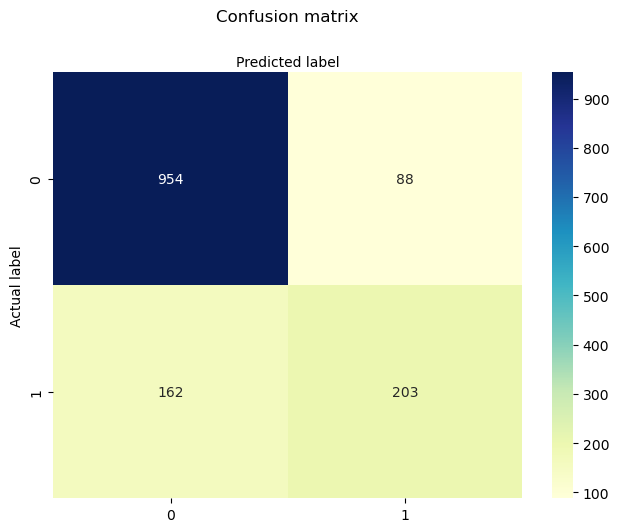

In [64]:
draw_confusion_matrix(y_test, pred)

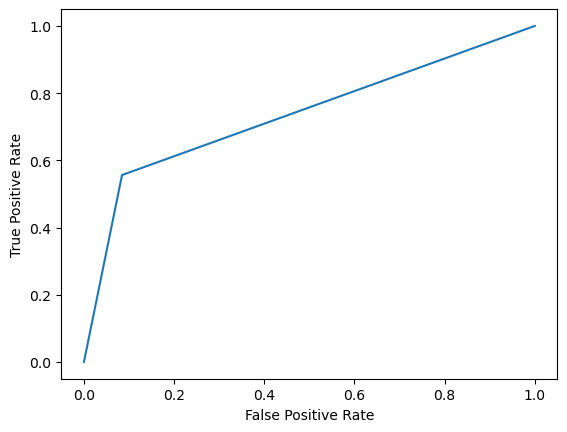

Logistic Regression AUC score: 0.7358557042568296
Accuracy: 0.822316986496091


In [65]:
draw_roc_curve(y_test, pred)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, pred)}')
print(f'Accuracy: {accuracy_score(y_test, pred)}')

pred_train = LR_model.predict(X_train)
performance_table['Train Score'].append(accuracy_score(y_train, pred_train))

performance_table['Test Score'].append(accuracy_score(y_test, pred))

## K-Nearest Neighbor

In [66]:
Knn = KNeighborsClassifier(n_neighbors = 5)
performance_table["Algorithm"].append("K-Nearest Neighbor")

In [67]:
Knn.fit(X_train, y_train)

pred = Knn.predict(X_test)

              precision    recall  f1-score   support

    No Churn       0.83      0.87      0.85      1042
       Churn       0.56      0.48      0.52       365

    accuracy                           0.77      1407
   macro avg       0.69      0.67      0.68      1407
weighted avg       0.76      0.77      0.76      1407



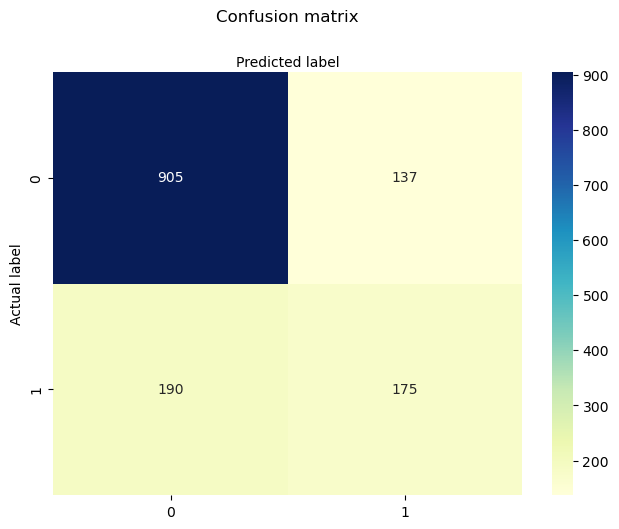

In [68]:
draw_confusion_matrix(y_test, pred)

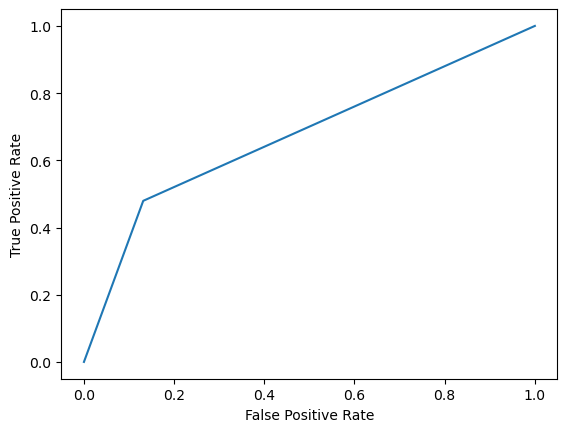

Logistic Regression AUC score: 0.6739870638655904
Accuracy: 0.767590618336887


In [69]:
draw_roc_curve(y_test, pred)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, pred)}')
print(f'Accuracy: {accuracy_score(y_test, pred)}')

pred_train = Knn.predict(X_train)
performance_table['Train Score'].append(accuracy_score(y_train, pred_train))

performance_table['Test Score'].append(accuracy_score(y_test, pred))

## Random Forest

In [70]:
Rfc = RandomForestClassifier(n_estimators = 1000 , oob_score = True, n_jobs = -1, 
                             random_state = 50, max_leaf_nodes = 30)
performance_table["Algorithm"].append("Random Forest")

In [71]:
Rfc.fit(X_train, y_train)

pred = Rfc.predict(X_test)

              precision    recall  f1-score   support

    No Churn       0.84      0.93      0.89      1042
       Churn       0.72      0.50      0.59       365

    accuracy                           0.82      1407
   macro avg       0.78      0.72      0.74      1407
weighted avg       0.81      0.82      0.81      1407



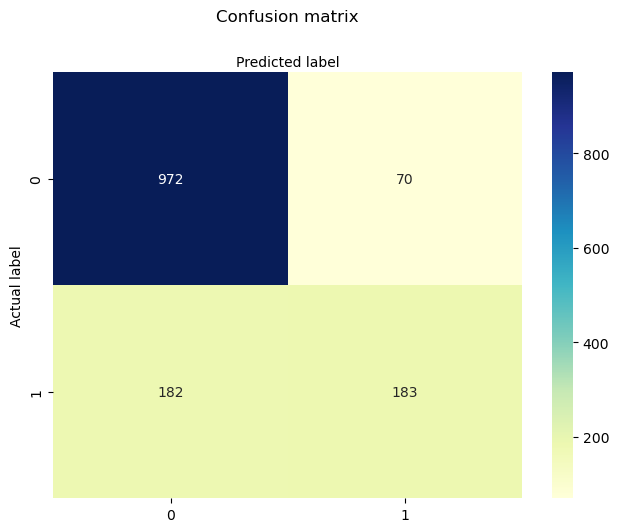

In [72]:
draw_confusion_matrix(y_test, pred)

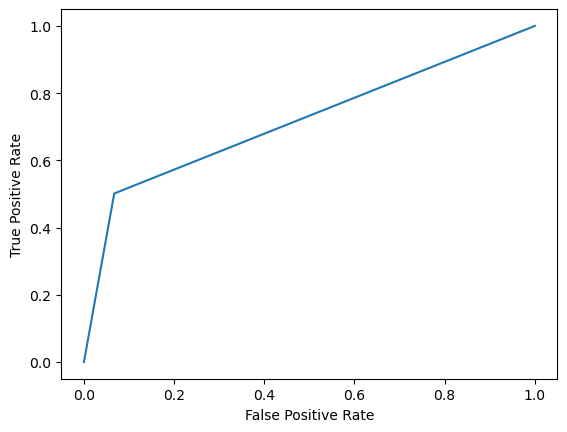

Logistic Regression AUC score: 0.7170956800673101
Accuracy: 0.8208955223880597


In [73]:
draw_roc_curve(y_test, pred)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, pred)}')
print(f'Accuracy: {accuracy_score(y_test, pred)}')

pred_train = Rfc.predict(X_train)
performance_table['Train Score'].append(accuracy_score(y_train, pred_train))

performance_table['Test Score'].append(accuracy_score(y_test, pred))

## Support Vector Machine

In [74]:
clf = svm.SVC(kernel='linear')
performance_table["Algorithm"].append("Support Vector Machine")

In [75]:
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      1042
       Churn       0.69      0.54      0.61       365

    accuracy                           0.82      1407
   macro avg       0.77      0.73      0.74      1407
weighted avg       0.81      0.82      0.81      1407



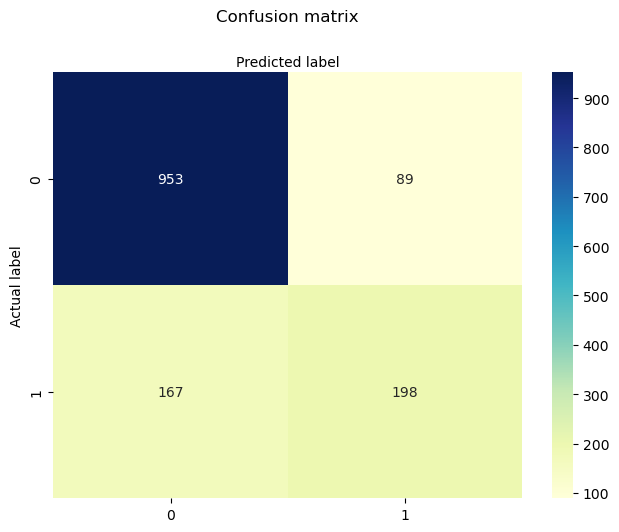

In [76]:
draw_confusion_matrix(y_test, pred)

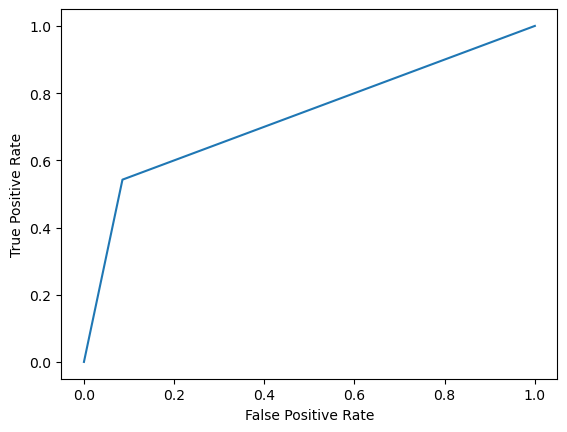

Logistic Regression AUC score: 0.7285265427392001
Accuracy: 0.8180525941719972


In [77]:
draw_roc_curve(y_test, pred)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, pred)}')
print(f'Accuracy: {accuracy_score(y_test, pred)}')

pred_train = clf.predict(X_train)
performance_table['Train Score'].append(accuracy_score(y_train, pred_train))

performance_table['Test Score'].append(accuracy_score(y_test, pred))

## XG Boost

In [78]:
xgb = XGBClassifier()
performance_table["Algorithm"].append("XG Boost")

In [79]:
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)

              precision    recall  f1-score   support

    No Churn       0.85      0.91      0.88      1042
       Churn       0.67      0.54      0.60       365

    accuracy                           0.81      1407
   macro avg       0.76      0.72      0.74      1407
weighted avg       0.80      0.81      0.81      1407



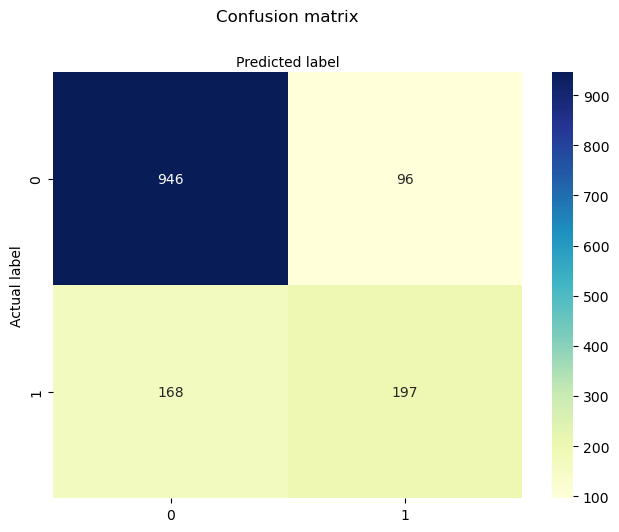

In [80]:
draw_confusion_matrix(y_test, pred)

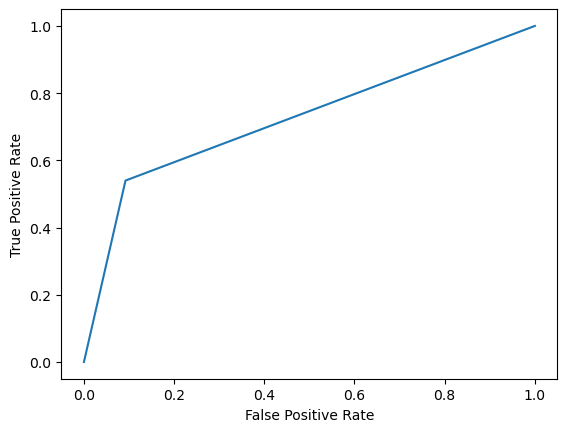

Logistic Regression AUC score: 0.7237977545815476
Accuracy: 0.8123667377398721


In [81]:
draw_roc_curve(y_test, pred)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, pred)}')
print(f'Accuracy: {accuracy_score(y_test, pred)}')

pred_train = xgb.predict(X_train)
performance_table['Train Score'].append(accuracy_score(y_train, pred_train))

performance_table['Test Score'].append(accuracy_score(y_test, pred))

## Neural Network

In [82]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

In [83]:
torch_X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
torch_y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)

In [84]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(40, 240)
        self.act1 = nn.ELU()
        
        self.hidden2 = nn.Linear(240, 120)
        self.act2 = nn.ELU()
        
        self.hidden3 = nn.Linear(120, 80)
        self.act3 = nn.ELU()
        
        self.hidden4 = nn.Linear(80, 40)
        self.act4 = nn.ELU()
        
        self.output = nn.Linear(40, 1)
        self.act_output = nn.Sigmoid()
        
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act_output(self.output(x))
        return x

In [85]:
model = Classifier().to(device)
print(model)
performance_table["Algorithm"].append("Neural Network")

Classifier(
  (hidden1): Linear(in_features=40, out_features=240, bias=True)
  (act1): ELU(alpha=1.0)
  (hidden2): Linear(in_features=240, out_features=120, bias=True)
  (act2): ELU(alpha=1.0)
  (hidden3): Linear(in_features=120, out_features=80, bias=True)
  (act3): ELU(alpha=1.0)
  (hidden4): Linear(in_features=80, out_features=40, bias=True)
  (act4): ELU(alpha=1.0)
  (output): Linear(in_features=40, out_features=1, bias=True)
  (act_output): Sigmoid()
)


In [86]:
loss_func = nn.BCELoss() # Binary cross entropy
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [87]:
X_train_batch = torch_X_train[0: 100]
y_train_batch = torch_y_train[0: 100]
y_pred = model(X_train_batch)

In [88]:
display(torch_y_train.shape)
display(y_train_batch.shape)
display(y_pred.shape)

torch.Size([5625, 1])

torch.Size([100, 1])

torch.Size([100, 1])

In [89]:
epochs = 5
batch = 100

for epoch in range(epochs):
    for i in range(0, len(torch_X_train), batch):
        X_train_batch = torch_X_train[i: i+batch]
        y_train_batch = torch_y_train[i: i+batch]
        
        y_pred = model(X_train_batch)
        
        loss = loss_func(y_pred, y_train_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [90]:
torch_X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_pred = model(torch_X_test)
y_pred = y_pred.round()

y_pred = y_pred.to(torch.device('cpu')).detach().numpy()

              precision    recall  f1-score   support

    No Churn       0.85      0.92      0.89      1042
       Churn       0.71      0.55      0.62       365

    accuracy                           0.83      1407
   macro avg       0.78      0.74      0.75      1407
weighted avg       0.82      0.83      0.82      1407



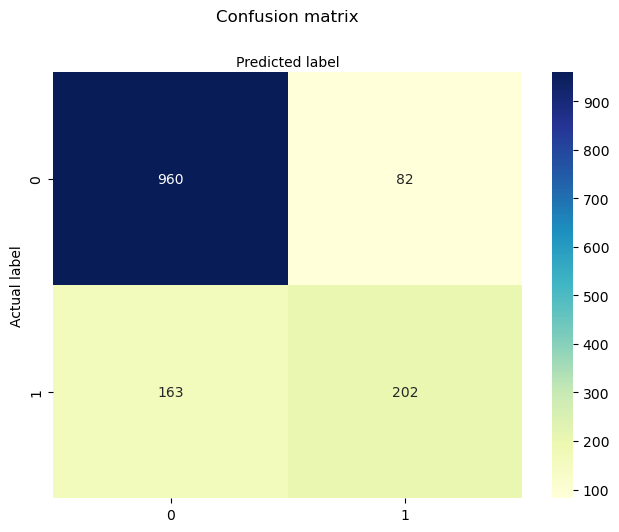

In [91]:
draw_confusion_matrix(y_test, y_pred)

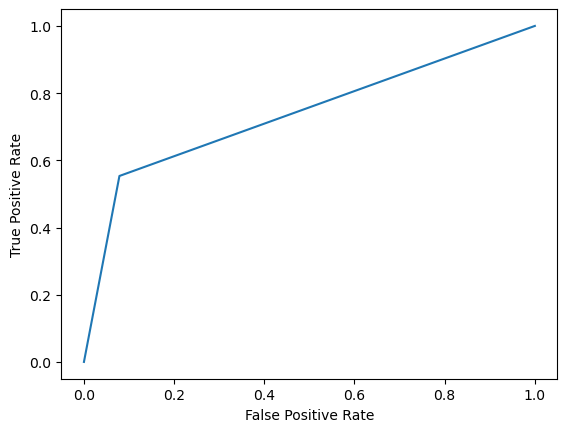

Logistic Regression AUC score: 0.7373649199379486
Accuracy: 0.8258706467661692


In [92]:
draw_roc_curve(y_test, y_pred)
print(f'Logistic Regression AUC score: {roc_auc_score(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

pred_train = model(torch_X_train)
pred_train = pred_train.round()

pred_train = pred_train.to(torch.device('cpu')).detach().numpy()
performance_table['Train Score'].append(accuracy_score(y_train, pred_train))

performance_table['Test Score'].append(accuracy_score(y_test, y_pred))

In [93]:
pd.DataFrame.from_dict(performance_table)

,Algorithm,Train Score,Test Score
0,Logistic Regression,0.796089,0.822317
1,K-Nearest Neighbor,0.830222,0.767591
2,Random Forest,0.809956,0.820896
3,Support Vector Machine,0.792711,0.818053
4,XG Boost,0.915200,0.812367
5,Neural Network,0.797689,0.825871
